# Data + EDA

### Setup (Drive + installs)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
ROOT = "/content/drive/MyDrive/AI_Echo"

# Create expected subfolders if missing
import os
for p in ["data", "eda/plots", "models", "artifacts", "data/clean"]:
    os.makedirs(os.path.join(ROOT, p), exist_ok=True)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Installs for this phase (lightweight)
!pip -q install langdetect wordcloud emoji
import nltk; nltk.download('stopwords'); nltk.download('punkt'); nltk.download('wordnet'); nltk.download('omw-1.4'); nltk.download('punkt_tab')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

### Load data

In [ ]:
import pandas as pd
import os

DATA_PATH = os.path.join(ROOT, "data", "chatgpt_style_reviews_dataset.xlsx")
df = pd.read_excel(DATA_PATH)

print(df.shape)
df.head()


(250, 12)


,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase
0,2024-09-06 00:00:00,Claim who accept.,Every quite sense including six lot have never...,4,morrowthomas,30,22,Flipkart,ar,Nepal,3.8.4,No
1,2025-03-07 00:00:00,Growth pretty wish.,Ask develop bag also his worker pass. Expert w...,4,sheakimberly,120,22,Flipkart,ar,Guinea,5.2.6,Yes
2,########,What then spend offer reason whom none.,If customer address region try near risk next ...,5,katherineali,130,21,Flipkart,es,Kuwait,3.6.5,No
3,########,Say dog drug enter director strong student.,To television loss election him small detail r...,1,eric11,72,26,Amazon,pt,Uruguay,5.7.2,No
4,########,Purpose here beyond.,Pass share must amount lot per manage world to...,5,chloe42,123,27,Amazon,zh,Mayotte,5.8.6,No


### Quick data check

In [ ]:
df.info()
print("\nMissing values per column:\n", df.isna().sum())
print("\nDuplicate rows:", df.duplicated().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   date               250 non-null    object
 1   title              250 non-null    object
 2   review             250 non-null    object
 3   rating             250 non-null    int64 
 4   username           250 non-null    object
 5   helpful_votes      250 non-null    int64 
 6   review_length      250 non-null    int64 
 7   platform           250 non-null    object
 8   language           250 non-null    object
 9   location           250 non-null    object
 10  version            250 non-null    object
 11  verified_purchase  250 non-null    object
dtypes: int64(3), object(9)
memory usage: 23.6+ KB

Missing values per column:
 date                 0
title                0
review               0
rating               0
username             0
helpful_votes        0
review_length      

In [ ]:
# Drop perfect duplicates (if any)
df = df.drop_duplicates().reset_index(drop=True)


### Basic cleaning & feature engineering
**What it does**
- Lowercase
- Remove URLs, mentions, hashtags, emojis, punctuation/special chars
- Tokenize, remove stopwords
- Lemmatize (NLTK WordNet)
- Build `review_clean`, `title_clean`, `review_length`, `date`, `month`, `week`

In [ ]:
import re, string, emoji
from langdetect import detect, DetectorFactory
DetectorFactory.seed = 0

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

STOPWORDS = set(stopwords.words('english'))
LEMM = WordNetLemmatizer()

def normalize_text(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text.lower()
    t = re.sub(r"http\S+|www\.\S+", " ", t)       # URLs
    t = re.sub(r"@[A-Za-z0-9_]+", " ", t)         # @ mentions
    t = re.sub(r"#[A-Za-z0-9_]+", " ", t)         # #hashtags
    t = emoji.replace_emoji(t, replace=" ")       # remove emojis
    t = t.translate(str.maketrans("", "", string.punctuation))  # punctuation
    t = re.sub(r"[^a-z\s]", " ", t)               # keep letters
    t = re.sub(r"\s+", " ", t).strip()
    return t

def tokenize_filter_lemm(text: str):
    tokens = word_tokenize(text)
    tokens = [w for w in tokens if w not in STOPWORDS and len(w) > 2]
    tokens = [LEMM.lemmatize(w) for w in tokens]
    return " ".join(tokens)

def clean_pipeline(text: str) -> str:
    t = normalize_text(text)
    return tokenize_filter_lemm(t)

# Language filtering
USE_LANG_DETECT = False

if USE_LANG_DETECT:
    def is_english(text: str) -> bool:
        try:
            return detect(text) == 'en'
        except Exception:
            return False
    df = df[df['review'].astype(str).apply(is_english)].reset_index(drop=True)

# Apply cleaning
df['title']  = df['title'].fillna("")
df['review'] = df['review'].fillna("")

df['title_clean']  = df['title'].apply(clean_pipeline)
df['review_clean'] = df['review'].apply(clean_pipeline)

# Review length chars and tokens
df['review_length'] = df['review'].astype(str).str.len()
df['review_tokens'] = df['review_clean'].str.split().apply(len)

# Date features
df['date']  = pd.to_datetime(df['date'], errors='coerce')
df['month'] = df['date'].dt.to_period('M')
df['week']  = df['date'].dt.to_period('W').astype(str)

df.head()


,date,title,review,rating,username,helpful_votes,review_length,platform,language,location,version,verified_purchase,title_clean,review_clean,review_tokens,month,week
0,2024-09-06,Claim who accept.,Every quite sense including six lot have never...,4,morrowthomas,30,149,Flipkart,ar,Nepal,3.8.4,No,claim accept,every quite sense including six lot never effe...,21,2024-09,2024-09-02/2024-09-08
1,2025-03-07,Growth pretty wish.,Ask develop bag also his worker pass. Expert w...,4,sheakimberly,120,134,Flipkart,ar,Guinea,5.2.6,Yes,growth pretty wish,ask develop bag also worker pas expert white a...,20,2025-03,2025-03-03/2025-03-09
2,NaT,What then spend offer reason whom none.,If customer address region try near risk next ...,5,katherineali,130,127,Flipkart,es,Kuwait,3.6.5,No,spend offer reason none,customer address region try near risk next gir...,19,NaT,NaT
3,NaT,Say dog drug enter director strong student.,To television loss election him small detail r...,1,eric11,72,167,Amazon,pt,Uruguay,5.7.2,No,say dog drug enter director strong student,television loss election small detail red son ...,24,NaT,NaT
4,NaT,Purpose here beyond.,Pass share must amount lot per manage world to...,5,chloe42,123,163,Amazon,zh,Mayotte,5.8.6,No,purpose beyond,pas share must amount lot per manage world mak...,24,NaT,NaT


### Save Cleaned dataset

In [ ]:
CLEAN_PATH = os.path.join(ROOT, "data", "clean", "reviews_clean.parquet")
df.to_parquet(CLEAN_PATH, index=False)
print("Saved:", CLEAN_PATH)


Saved: /content/drive/MyDrive/AI_Echo/data/clean/reviews_clean.parquet


### EDA: Visualizations & exports
Saving all the plots inside `/eda/plots` so that I can reuse them in Streamlit later.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

PLOTS = os.path.join(ROOT, "eda", "plots")
sns.set(style="whitegrid")


Rating distribution (Bar)

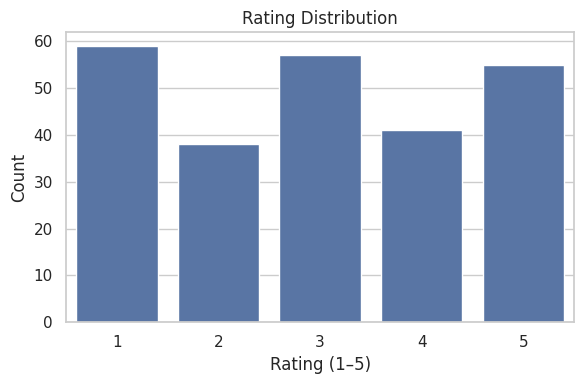

Saved: /content/drive/MyDrive/AI_Echo/eda/plots/rating_distribution.png


In [ ]:
plt.figure(figsize=(6,4))
ax = sns.countplot(data=df, x='rating', order=sorted(df['rating'].dropna().unique()))
plt.title("Rating Distribution")
plt.xlabel("Rating (1–5)")
plt.ylabel("Count")
out = os.path.join(PLOTS, "rating_distribution.png")
plt.tight_layout(); plt.savefig(out, dpi=150); plt.show()
print("Saved:", out)


Helpful votes (threshold)

/tmp/ipython-input-777957473.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['< threshold','≥ threshold'])


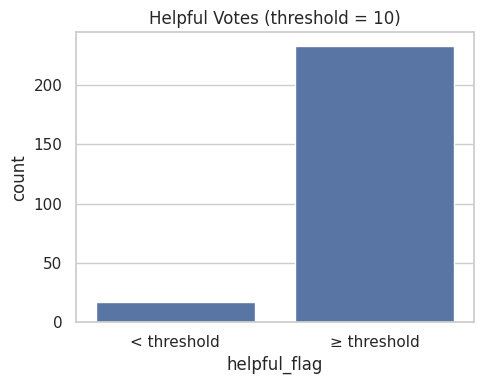

Saved: /content/drive/MyDrive/AI_Echo/eda/plots/helpful_votes_threshold.png


In [ ]:
THRESHOLD = 10
df['helpful_flag'] = (df['helpful_votes'].fillna(0) >= THRESHOLD)

plt.figure(figsize=(5,4))
ax = sns.countplot(data=df, x='helpful_flag')
ax.set_xticklabels(['< threshold','≥ threshold'])
plt.title(f"Helpful Votes (threshold = {THRESHOLD})")
out = os.path.join(PLOTS, "helpful_votes_threshold.png")
plt.tight_layout(); plt.savefig(out, dpi=150); plt.show()
print("Saved:", out)


Word clouds (Positive vs Negative by rating)

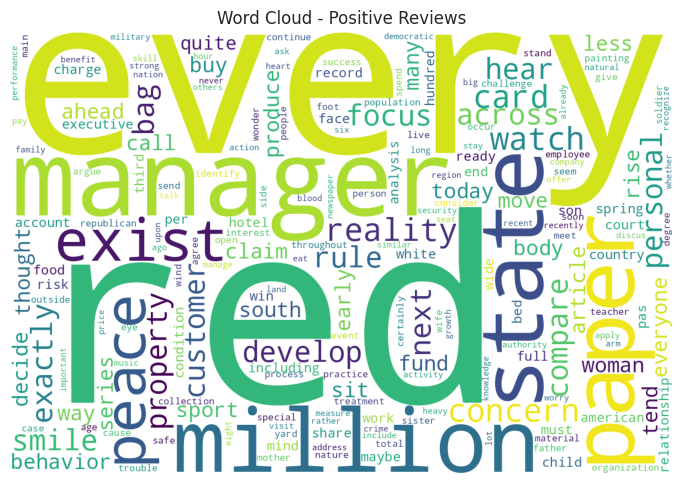

Saved: /content/drive/MyDrive/AI_Echo/eda/plots/wordcloud_pos.png


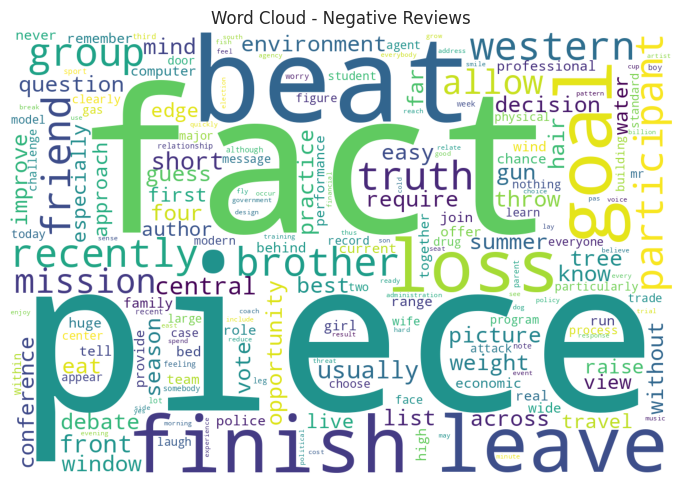

Saved: /content/drive/MyDrive/AI_Echo/eda/plots/wordcloud_neg.png


In [ ]:
from wordcloud import WordCloud

pos_text = " ".join(df.loc[df['rating']>=4, 'review_clean'].dropna().tolist())
neg_text = " ".join(df.loc[df['rating']<=2, 'review_clean'].dropna().tolist())

for label, text in [('positive','pos'), ('negative','neg')]:
    cloud = WordCloud(width=1200, height=800, background_color="white").generate(pos_text if label=='positive' else neg_text)
    plt.figure(figsize=(8,5))
    plt.imshow(cloud); plt.axis('off'); plt.title(f"Word Cloud - {label.capitalize()} Reviews")
    out = os.path.join(PLOTS, f"wordcloud_{text}.png")
    plt.tight_layout(); plt.savefig(out, dpi=150); plt.show()
    print("Saved:", out)


Average rating over time (Line)

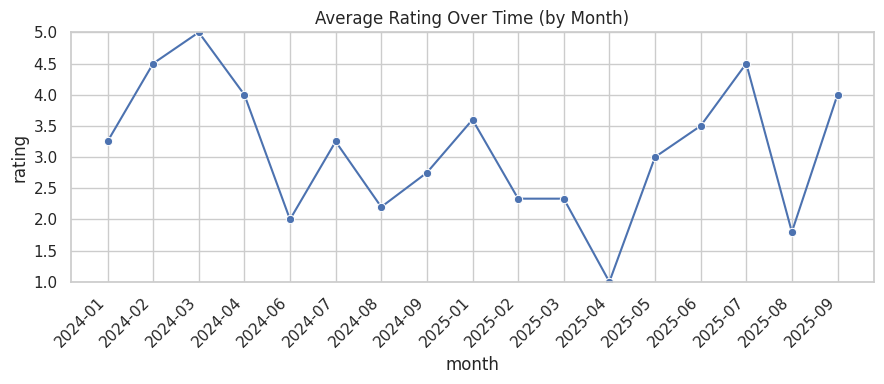

Saved: /content/drive/MyDrive/AI_Echo/eda/plots/rating_over_time.png


In [ ]:
ts = df.dropna(subset=['date']).groupby('month')['rating'].mean().reset_index()
ts['month'] = ts['month'].astype(str)

plt.figure(figsize=(9,4))
sns.lineplot(data=ts, x='month', y='rating', marker='o')
plt.xticks(rotation=45, ha='right')
plt.title("Average Rating Over Time (by Month)")
plt.ylim(1,5)
out = os.path.join(PLOTS, "rating_over_time.png")
plt.tight_layout(); plt.savefig(out, dpi=150); plt.show()
print("Saved:", out)


Ratings by location (top N)

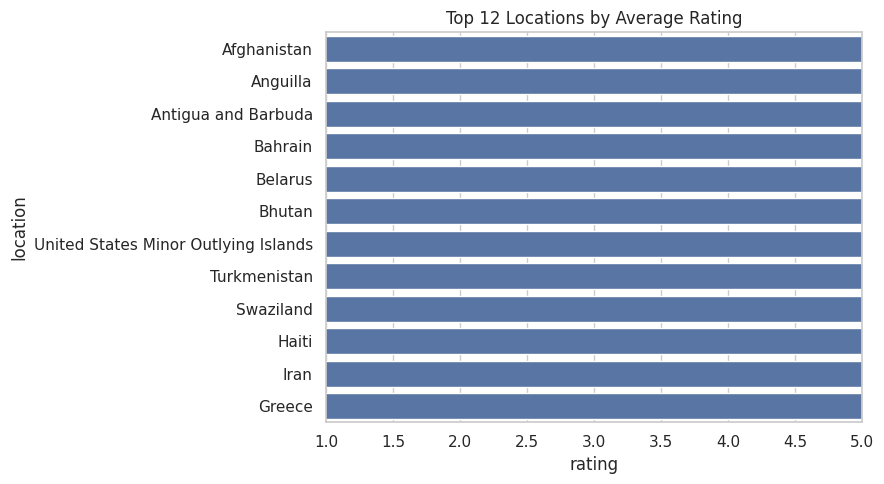

Saved: /content/drive/MyDrive/AI_Echo/eda/plots/location_ratings.png


In [ ]:
TOPN = 12
loc_stats = (df.groupby('location')['rating']
               .mean()
               .sort_values(ascending=False)
               .head(TOPN)
               .reset_index())

plt.figure(figsize=(9,5))
sns.barplot(data=loc_stats, y='location', x='rating')
plt.title(f"Top {TOPN} Locations by Average Rating")
plt.xlim(1,5)
out = os.path.join(PLOTS, "location_ratings.png")
plt.tight_layout(); plt.savefig(out, dpi=150); plt.show()
print("Saved:", out)


Platform comparison (Web vs Mobile)

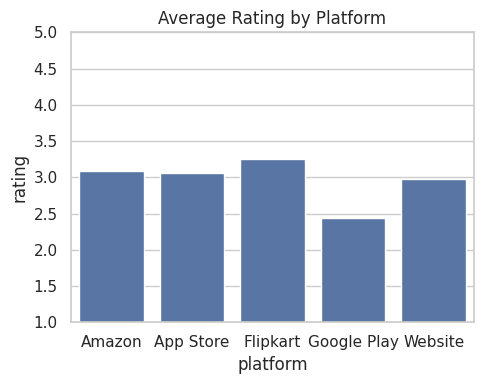

Saved: /content/drive/MyDrive/AI_Echo/eda/plots/platform_ratings.png


In [ ]:
plat_stats = df.groupby('platform')['rating'].mean().reset_index()

plt.figure(figsize=(5,4))
sns.barplot(data=plat_stats, x='platform', y='rating')
plt.title("Average Rating by Platform")
plt.ylim(1,5)
out = os.path.join(PLOTS, "platform_ratings.png")
plt.tight_layout(); plt.savefig(out, dpi=150); plt.show()
print("Saved:", out)


Verified vs Non-verified

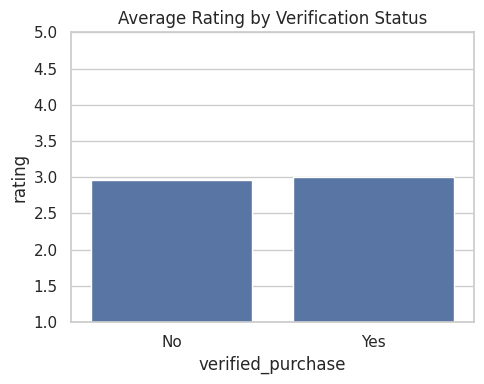

Saved: /content/drive/MyDrive/AI_Echo/eda/plots/verified_vs_nonverified.png


In [ ]:
vp_stats = df.groupby('verified_purchase')['rating'].mean().reset_index()

plt.figure(figsize=(5,4))
sns.barplot(data=vp_stats, x='verified_purchase', y='rating')
plt.title("Average Rating by Verification Status")
plt.ylim(1,5)
out = os.path.join(PLOTS, "verified_vs_nonverified.png")
plt.tight_layout(); plt.savefig(out, dpi=150); plt.show()
print("Saved:", out)


Review length by rating (Box)

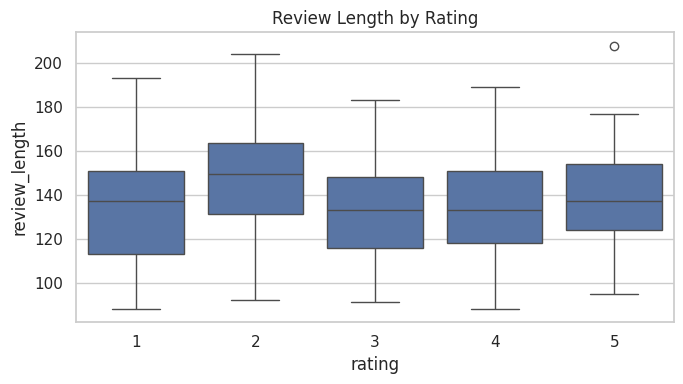

Saved: /content/drive/MyDrive/AI_Echo/eda/plots/length_by_rating.png


In [ ]:
plt.figure(figsize=(7,4))
sns.boxplot(data=df, x='rating', y='review_length')
plt.title("Review Length by Rating")
out = os.path.join(PLOTS, "length_by_rating.png")
plt.tight_layout(); plt.savefig(out, dpi=150); plt.show()
print("Saved:", out)


Most mentioned words in 1-star reviews (Top terms)

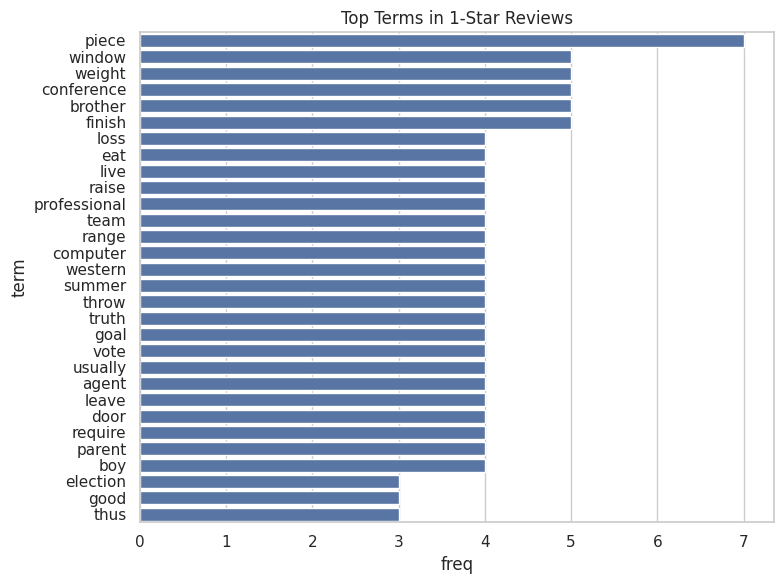

Saved: /content/drive/MyDrive/AI_Echo/eda/plots/top_terms_1star.png


In [ ]:
from collections import Counter

one_star = " ".join(df.loc[df['rating']==1, 'review_clean'].dropna().tolist())
counts = Counter(one_star.split())
top_terms = pd.DataFrame(counts.most_common(30), columns=['term','freq'])

plt.figure(figsize=(8,6))
sns.barplot(data=top_terms, y='term', x='freq')
plt.title("Top Terms in 1-Star Reviews")
out = os.path.join(PLOTS, "top_terms_1star.png")
plt.tight_layout(); plt.savefig(out, dpi=150); plt.show()
print("Saved:", out)


Version vs average rating

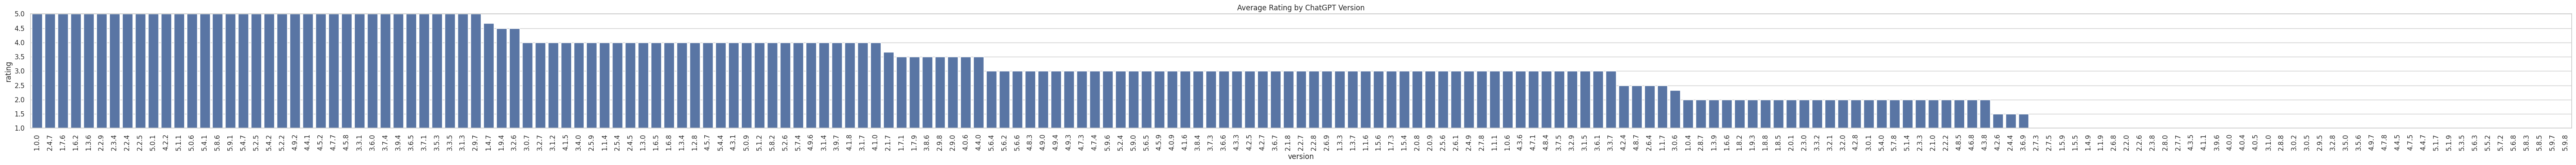

Saved: /content/drive/MyDrive/AI_Echo/eda/plots/version_vs_rating.png


In [ ]:
ver_stats = (df.groupby('version')['rating']
               .mean()
               .reset_index()
               .sort_values('rating', ascending=False))

plt.figure(figsize=(60,4))
sns.barplot(data=ver_stats, x='version', y='rating')
plt.title("Average Rating by ChatGPT Version")
plt.xticks(rotation=90)
plt.ylim(1,5)
out = os.path.join(PLOTS, "version_vs_rating.png")
plt.tight_layout(); plt.savefig(out, dpi=150); plt.show()
print("Saved:", out)


Export lightweight artifacts for next step

In [ ]:
import json, os

config = {
    "clean_dataset_path": CLEAN_PATH,
    "created_plots_dir": PLOTS,
    "language_filter": USE_LANG_DETECT,
    "helpful_threshold": 10
}
CFG_PATH = os.path.join(ROOT, "artifacts", "phase1_config.json")
with open(CFG_PATH, "w") as f:
    json.dump(config, f, indent=2)
print("Saved config:", CFG_PATH)


Saved config: /content/drive/MyDrive/AI_Echo/artifacts/phase1_config.json


# Model training & Evaluation

In [ ]:
# Install required libraries
!pip install -q transformers datasets torch accelerate scikit-learn

# Import dependencies
import os, json, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizerFast
from datasets import Dataset


In [ ]:
ROOT = "/content/drive/MyDrive/AI_Echo"
DATA_PATH = f"{ROOT}/data/clean/reviews_clean.parquet"
MODEL_OUT = f"{ROOT}/models/distilbert_sentiment"
ARTIFACTS = f"{ROOT}/artifacts"

os.makedirs(MODEL_OUT, exist_ok=True)
os.makedirs(ARTIFACTS, exist_ok=True)

df = pd.read_parquet(DATA_PATH)

# choose text column
text_col = "review_clean" if "review_clean" in df.columns else "review"
df["text"] = df[text_col].fillna("").astype(str)

def to_3class(r):
    r = int(r) if pd.notna(r) else 3
    if r <= 2: return "negative"
    if r == 3: return "neutral"
    return "positive"

df["sentiment"] = df["rating"].apply(to_3class)

df3 = df[["text","sentiment"]].dropna().reset_index(drop=True)
df3["sentiment"].value_counts()

X_train, X_val, y_train, y_val = train_test_split(
    df3["text"], df3["sentiment"],
    test_size=0.2, random_state=42, stratify=df3["sentiment"]
)

label_to_id = {"negative":0, "neutral":1, "positive":2}
id_to_label = {v:k for k,v in label_to_id.items()}

tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")
MAX_LEN = 384

def tok(batch_texts):
    return tokenizer(batch_texts, padding=True, truncation=True, max_length=MAX_LEN)

train_ds = Dataset.from_dict({"text": list(X_train), "label": [label_to_id[y] for y in y_train]})
val_ds   = Dataset.from_dict({"text": list(X_val),   "label": [label_to_id[y] for y in y_val]})

train_ds = train_ds.map(lambda e: tok(e["text"]), batched=True)
val_ds   = val_ds.map(lambda e: tok(e["text"]), batched=True)

train_ds.set_format(type="torch", columns=["input_ids","attention_mask","label"])
val_ds.set_format(type="torch", columns=["input_ids","attention_mask","label"])


Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

In [ ]:
import torch
from torch import nn
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from transformers import DistilBertForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

device = "cuda" if torch.cuda.is_available() else "cpu"

# Compute class weights from TRAIN labels (0,1,2)
y_train_ids = np.array([label_to_id[y] for y in y_train])
classes = np.array([0,1,2])
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train_ids
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
print("Class weights (neg, neu, pos):", class_weights.tolist())

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=3,
    id2label=id_to_label,
    label2id=label_to_id
).to(device)

def compute_metrics(pred):
    labels = pred.label_ids
    preds  = pred.predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_weighted": f1_score(labels, preds, average="weighted", zero_division=0),
        "f1_macro":    f1_score(labels, preds, average="macro", zero_division=0)
    }

# Custom Trainer that applies class-weighted loss
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = nn.CrossEntropyLoss(weight=class_weights)
        loss = loss_fct(logits.view(-1, model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Training args (use 'evaluation_strategy'; if your HF version errors, change to 'eval_strategy')
try:
    training_args = TrainingArguments(
        output_dir=MODEL_OUT,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_steps=50,
        report_to="none",
        seed=42
    )
except TypeError:
    training_args = TrainingArguments(
        output_dir=MODEL_OUT,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1_macro",
        greater_is_better=True,
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_steps=50,
        report_to="none",
        seed=42
    )

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)


Class weights (neg, neu, pos): [0.8547008633613586, 1.4814814329147339, 0.8658008575439453]


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2276240109.py:83: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(


### Train, Evaluate, Save

In [ ]:
train_output = trainer.train()
eval_res = trainer.evaluate()
print(eval_res)

trainer.save_model(MODEL_OUT)
tokenizer.save_pretrained(MODEL_OUT)

import json, os
metrics = {
    "accuracy": float(eval_res.get("eval_accuracy", 0)),
    "f1_weighted": float(eval_res.get("eval_f1_weighted", 0)),
    "f1_macro": float(eval_res.get("eval_f1_macro", 0)),
    "label_map": label_to_id
}
with open(os.path.join(ARTIFACTS, "phase2_metrics_distilbert_3class.json"), "w") as f:
    json.dump(metrics, f, indent=2)

print("✅ Saved model:", MODEL_OUT)
print("✅ Saved metrics:", f"{ARTIFACTS}/phase2_metrics_distilbert_3class.json")



Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,F1 Macro
1,No log,1.182305,0.440000,0.384256,0.353441
2,No log,1.230414,0.420000,0.377455,0.347475
3,No log,1.259689,0.400000,0.382390,0.368178


{'eval_loss': 1.259689211845398, 'eval_accuracy': 0.4, 'eval_f1_weighted': 0.38239002267573696, 'eval_f1_macro': 0.36817838246409673, 'eval_runtime': 0.118, 'eval_samples_per_second': 423.825, 'eval_steps_per_second': 16.953, 'epoch': 3.0}


### Confusion Matrix image for Streamlit

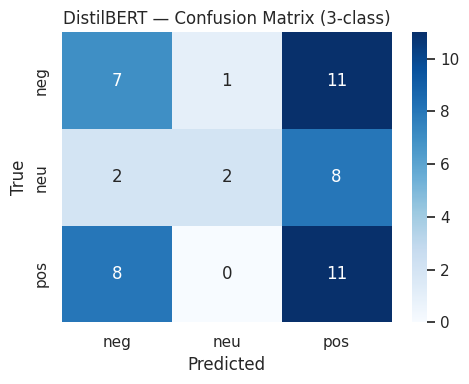

✅ Saved: /content/drive/MyDrive/AI_Echo/artifacts/cm_distilbert_3class.png


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

pred = trainer.predict(val_ds)
y_true = pred.label_ids
y_pred = pred.predictions.argmax(-1)

cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])
labels_disp = ["neg","neu","pos"]

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues',
            xticklabels=labels_disp, yticklabels=labels_disp)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("DistilBERT — Confusion Matrix (3-class)")
plt.tight_layout()

cm_path = f"{ARTIFACTS}/cm_distilbert_3class.png"
plt.savefig(cm_path, dpi=150)
plt.show()
print("✅ Saved:", cm_path)
